<a href="https://colab.research.google.com/github/prajeet26/Twitter_disaster_classification_using_BERT/blob/main/DisBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import string

!pip install transformers==4.30
!pip install transformers[torch]
!pip install accelerate>=0.20.1
!pip install torch
!pip install datasets
!pip install emoji
from datasets import Dataset
from transformers import BertForSequenceClassification, BertweetTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
!pip install evaluate
import evaluate

**EDA**

In [23]:
df_train = pd.read_csv('/content/drive/MyDrive/Distweets/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Distweets/test.csv')


In [24]:
print(df_train.columns)
print(df_train.shape)
df_train


Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [25]:
print(df_test.columns)
print(df_test.shape)
df_test

Index(['id', 'keyword', 'location', 'text'], dtype='object')
(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


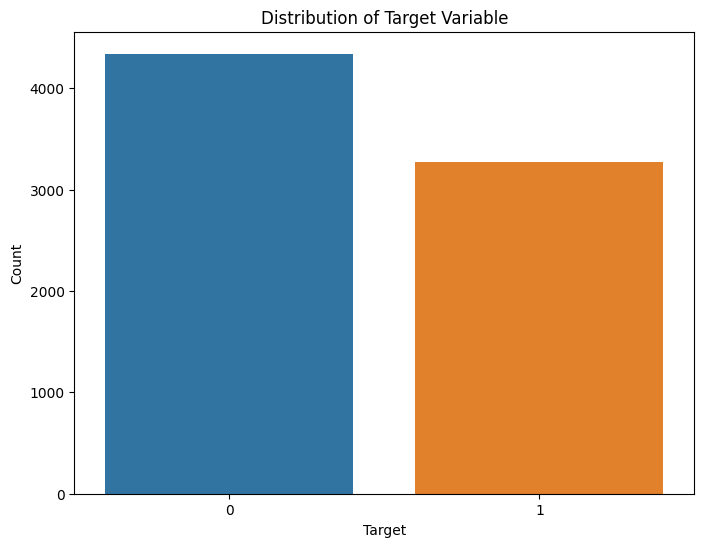

In [26]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df_train)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


In [27]:
class_counts = df_train['target'].value_counts()
print('0 = Not a Disaster Tweet counts, 1 = Disaster Tweet counts')
print(class_counts)

0 = Not a Disaster Tweet counts, 1 = Disaster Tweet counts
0    4342
1    3271
Name: target, dtype: int64


0 = Not a Disaster Tweet counts, 1 = Disaster Tweet counts
0    4342
1    3271
Name: target, dtype: int64


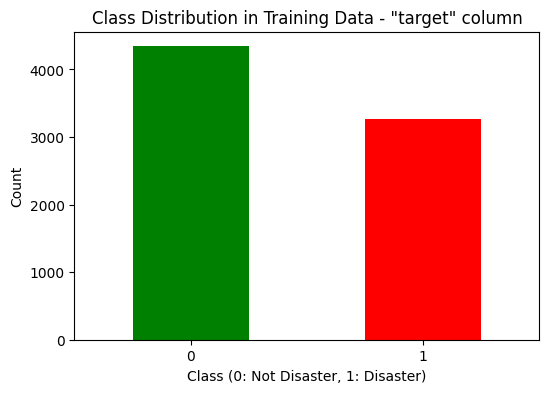

In [28]:
class_counts = df_train['target'].value_counts()
print('0 = Not a Disaster Tweet counts, 1 = Disaster Tweet counts')
print(class_counts)

# Create a bar plot for the Class Distribution
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution in Training Data - "target" column')
plt.xlabel('Class (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [29]:
missing_values = df_train.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [30]:
import plotly.express as px

df_train['keyword'].fillna("", inplace=True)
df_train['location'].fillna("", inplace=True)

# Create a new feature 'tweet_length' representing the length of each tweet
df_train['tweet_length'] = df_train['text'].apply(len)

# Check again for missing values
missing_values_after_handling = df_train.isnull().sum()
print("\nMissing Values After Handling:")
print(missing_values_after_handling)
df_train['tweet_length'] = df_train['text'].apply(len)

# Advanced Visualization: Interactive Histogram
fig = px.histogram(
    df_train,
    x='tweet_length',
    color='target',
    marginal='rug',
    nbins=100,
    labels={'tweet_length': 'Tweet Length'},
    title='Interactive Histogram of Tweet Lengths by Disaster and Non-Disaster Tweets',
    opacity=0.8,
    barmode='overlay',  # Overlay histograms for comparison
)

fig.show()


Missing Values After Handling:
id              0
keyword         0
location        0
text            0
target          0
tweet_length    0
dtype: int64


In [31]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    return re.sub(url_pattern, '', text)

# Apply the remove_urls function to the 'text' column of both training and testing datasets
df_train['text'] = df_train['text'].apply(remove_urls)
df_test['text'] = df_test['text'].apply(remove_urls)

In [32]:
def remove_html_tags(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    return cleantext


df_train['text'] = df_train['text'].apply(remove_html_tags)
df_test['text'] = df_test['text'].apply(remove_html_tags)

In [35]:
import re

def remove_emojis(text):
    emoji_pattern = re.compile(r"["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U0001FB00-\U0001FBFF"  # Symbols for Legacy Computing
                               u"\U0001F004"             # Mahjong Tile Red Dragon
                               u"\U0001F0CF"             # Playing Cards Joker
                               u"\U0001F170-\U0001F251"  # Enclosed Ideographic Supplement
                               u"\U0001F300-\U0001F320"  # Miscellaneous Symbols and Pictographs
                               u"\U0001F321-\U0001F32C"  # Enclosed CJK Letters and Months
                               "]+", flags=re.UNICODE)

    # Remove emojis and emoticons from the text
    clean_text = emoji_pattern.sub(r'', text)
    return clean_text

# Apply the remove_emojis function to the 'text' column of both training and testing datasets
df_train['text'] = df_train['text'].apply(remove_emojis)
df_test['text'] = df_test['text'].apply(remove_emojis)

# Check the cleaned text
print(df_train['text'].head())
print(df_test['text'].head())


0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object
0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: text, dtype: object


In [38]:
#  a dictionary of common contractions and their expanded forms
contraction_dict = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "might've": "might have",
    "must've": "must have",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",
    "I'd've": "I would have",
    "she'd've": "she would have",
    "should've": "should have",
    "could've": "could have",
    "might've": "might have",
    "would've": "would have"
}

def expand_contractions(text):
    for contraction, expansion in contraction_dict.items():
        text = text.replace(contraction, expansion)
    return text


df_train['text'] = df_train['text'].apply(expand_contractions)
df_test['text'] = df_test['text'].apply(expand_contractions)

In [41]:
def remove_punctuation(text):
    punctuation_pattern = r"[{}]".format(re.escape(string.punctuation))
    clean_text = re.sub(punctuation_pattern, '', text)
    return clean_text


df_train['text'] = df_train['text'].apply(remove_punctuation)
df_test['text'] = df_test['text'].apply(remove_punctuation)

In [49]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return clean_text
df_train['text'] = df_train['text'].apply(remove_special_characters)
df_test['text'] = df_test['text'].apply(remove_special_characters)

In [50]:
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

In [51]:
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))

Word Count Statistics of the Tweets:
 count    7613.000000
mean       14.138185
std         5.951753
min         1.000000
25%        10.000000
50%        14.000000
75%        18.000000
max        32.000000
Name: word_count, dtype: float64


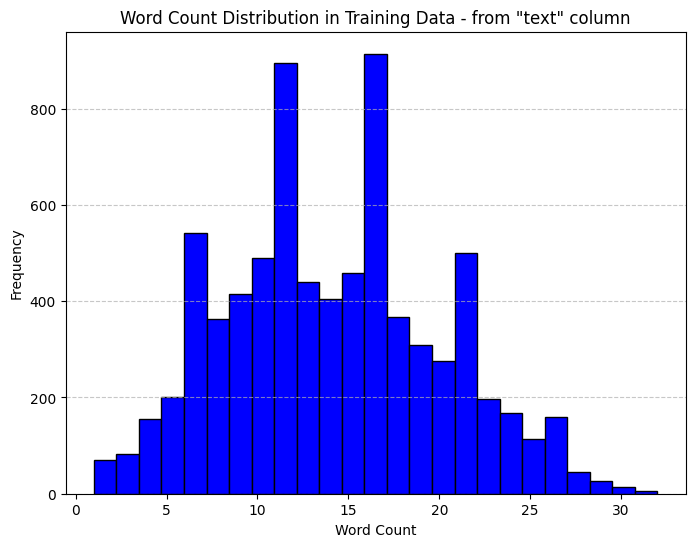

In [52]:
word_count_stats = df_train['word_count'].describe()
print("Word Count Statistics of the Tweets:\n", word_count_stats)

plt.figure(figsize=(8, 6))
plt.hist(df_train['word_count'], bins=25, color='blue', edgecolor='black')
plt.title('Word Count Distribution in Training Data - from "text" column')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [56]:
df_train

,id,text,labels,tweet_length
0,1,our deeds are the reason of this earthquake ma...,1,69
1,4,forest fire near la ronge sask canada,1,38
2,5,all residents asked to shelter in place are be...,1,133
3,6,13000 people receive wildfires evacuation orde...,1,65
4,7,just got sent this photo from ruby alaska as s...,1,88
...,...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,1,83
7609,10870,ariaahrary thetawniest the out of control wild...,1,125
7610,10871,m194 0104 utc5km s of volcano hawaii,1,65
7611,10872,police investigating after an ebike collided w...,1,137


In [58]:
df_train.rename(columns={"target": "labels"}, inplace=True)
train_data, dev_data = train_test_split(df_train, test_size=0.15, random_state=42)

# 'train_data' contains 85% of the original training data
# 'dev_data' contains 15% of the original training data

In [59]:
train_data

,id,text,labels,tweet_length
2318,3334,splottdave teampalestina thats about 28700 pal...,1,139
6341,9064,rightways building structural integrity amp fa...,1,140
1097,1587,london life photos of a beautiful bombedout br...,0,82
548,797,civil war general battle bull run hero colonel...,1,126
6521,9325,mochichiiiii hikagezero its impossible for me ...,0,99
...,...,...,...,...
5226,7470,eganator2000 there are not many obliteration s...,0,96
5390,7691,just had a panic attack bc i do not have enoug...,0,132
860,1242,omron hem712c automatic blood pressure monitor...,0,121
7603,10862,officials say a quarantine is in place at an a...,1,136


In [60]:
dev_data

,id,text,labels,tweet_length
2644,3796,so you have a new weapon that can cause unimag...,1,66
2227,3185,the famping things i do for gishwhes just got ...,0,119
5448,7769,dt georgegalloway rt galloway4mayor the col po...,1,125
132,191,aftershock back to school kick off was great i...,0,114
6845,9810,in response to trauma children of addicts deve...,0,105
...,...,...,...,...
1393,2010,\nwarfighting robots could reduce civilian cas...,1,131
1335,1929,fewmoretweets all lives matter just not a fan ...,1,119
5717,8159,womans gps app guides rescuers to injured bike...,1,89
4921,7009,tonight its going to be mayhem 4playthursdays...,0,116


In [63]:
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

In [64]:
train_dataset = Dataset.from_pandas(train_data)
dev_dataset = Dataset.from_pandas(dev_data)
test_dataset = Dataset.from_pandas(df_test)

print ('TRAIN', train_dataset)
print ('DEV', dev_dataset)
print ('TEST', test_dataset)

TRAIN Dataset({
    features: ['id', 'text', 'labels', 'tweet_length', '__index_level_0__'],
    num_rows: 6471
})
DEV Dataset({
    features: ['id', 'text', 'labels', 'tweet_length', '__index_level_0__'],
    num_rows: 1142
})
TEST Dataset({
    features: ['id', 'keyword', 'location', 'text', 'word_count'],
    num_rows: 3263
})


In [65]:
df_train.reset_index(drop=True, inplace=True)

In [66]:
train_dataset = Dataset.from_pandas(train_data)
dev_dataset = Dataset.from_pandas(dev_data)
test_dataset = Dataset.from_pandas(df_test)

print ('TRAIN', train_dataset)
print ('DEV', dev_dataset)
print ('TEST', test_dataset)

TRAIN Dataset({
    features: ['id', 'text', 'labels', 'tweet_length', '__index_level_0__'],
    num_rows: 6471
})
DEV Dataset({
    features: ['id', 'text', 'labels', 'tweet_length', '__index_level_0__'],
    num_rows: 1142
})
TEST Dataset({
    features: ['id', 'keyword', 'location', 'text', 'word_count'],
    num_rows: 3263
})


BerTweet introduction

In [68]:
model_name = "vinai/bertweet-base"

# Load the pre-trained BERTweet model
bertweet_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Initialize the tokenizer for BERTweet
tokenizer = BertweetTokenizer.from_pretrained(
    model_name,
    use_fast=False)


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertForSequenceClassification: ['roberta.encoder.layer.10.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.self.key.weight', 'roberta.encoder.layer.3.intermediate.dense.bias', 'roberta.encoder.layer.9.output.LayerNorm.bias', 'roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.6.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.dense.weight', 'roberta.encoder.layer.1.attention.self.value.weight', 'roberta.encoder.layer.6.output.dense.bias', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.7.output.LayerNorm.bias', 'roberta.encoder.layer.1.intermediate.dense.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.key.bias', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.9.attention.self.key.weight', 'roberta.encoder.la

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [69]:
max_length = 30

def preprocess_dataencoding(dataset, tokenizer, max_length):
    text = dataset["text"]


    encoded_input = tokenizer(
        text,
        padding="max_length",
        max_length=max_length,
        truncation=True,
        return_tensors="pt"
    )

    return encoded_input

In [70]:
train_tokenized_encoded = train_dataset.map(lambda x: preprocess_dataencoding(x, tokenizer, max_length), batched=True)
dev_tokenized_encoded = dev_dataset.map(lambda x: preprocess_dataencoding(x, tokenizer, max_length), batched=True)
test_tokenized_encoded = test_dataset.map(lambda x: preprocess_dataencoding(x, tokenizer, max_length), batched=True)

print(train_tokenized_encoded[0])
print(tokenizer.convert_ids_to_tokens(train_tokenized_encoded[0]["input_ids"]))

Map:   0%|          | 0/6471 [00:00<?, ? examples/s]

Map:   0%|          | 0/1142 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

{'id': 3334, 'text': 'splottdave teampalestina thats about 28700 palestinian homes demolished now by israel since 1967 w 0 israeli home demolished potus', 'labels': 1, 'tweet_length': 139, '__index_level_0__': 2318, 'input_ids': [0, 1656, 1143, 2442, 32549, 8876, 5354, 638, 2110, 1771, 925, 62, 3730, 8340, 5158, 2110, 35480, 5437, 27286, 77, 61, 37069, 324, 12522, 293, 895, 60318, 13735, 219, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['<s>', 'sp@@', 'lo@@', 'tt@@', 'dave', 'tea@@', 'mp@@', 'al@@', 'est@@', 'ina', 'thats', 'about', '28@@', '700', 'pal@@', 'est@@', 'inian', 'homes', 'demolished', 'now', 'by', 'israel', 'since', '1967', 'w', '0', 'isra@@', 'eli', 'home', '</s>']


In [71]:
epochs = 8
batch_size = 16
learning_rate = 1e-5
output_dir = "model_checkpoints"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    evaluation_strategy="epoch",  # Perform evaluation at the end of each epoch
    save_strategy="epoch",
    learning_rate=learning_rate,
    load_best_model_at_end=True,
    resume_from_checkpoint=True   # Re-start the training process by loading the model from the last saved checkpoint (due to constant disconnection issues from GDrive)
)


# "Trainer" for fine-tuning the model
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=bertweet_model,
    args=training_args,
    train_dataset=train_tokenized_encoded,
    data_collator=data_collator,
    eval_dataset=dev_tokenized_encoded    # Development dataset for evaluation
)

METHOD 1: F1 Score on the Training dataset: 0.0000


METHOD 2: F1 Score on the Training Dataset: 0.0000


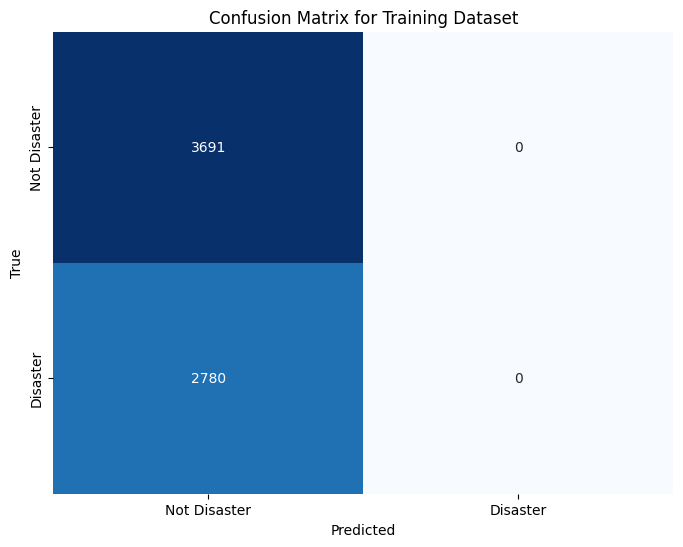

In [72]:
train_predictions = trainer.predict(train_tokenized_encoded)

# Extract predicted labels and true labels for training dataset
train_pred_labels = train_predictions.predictions.argmax(axis=1)
train_true_labels = train_tokenized_encoded["labels"]

# Compute F1 score for training dataset
train_f1score = f1_score(train_true_labels, train_pred_labels)

# Print F1 scores
print(f"METHOD 1: F1 Score on the Training dataset: {train_f1score:.4f}")
# Calculate the F1 score using the evaluate library
f1_metric = evaluate.load("f1")
f1_score = f1_metric.compute(predictions=train_pred_labels, references=train_true_labels)

print(f"METHOD 2: F1 Score on the Training Dataset: {f1_score['f1']:.4f}")
# Define class names
class_names = ['Not Disaster', 'Disaster']

# Calculate the confusion matrix
cm = confusion_matrix(train_true_labels, train_pred_labels)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Training Dataset')
plt.show()












































































































































































































































































































































































































